In [2]:
from matplotlib import pyplot as plt

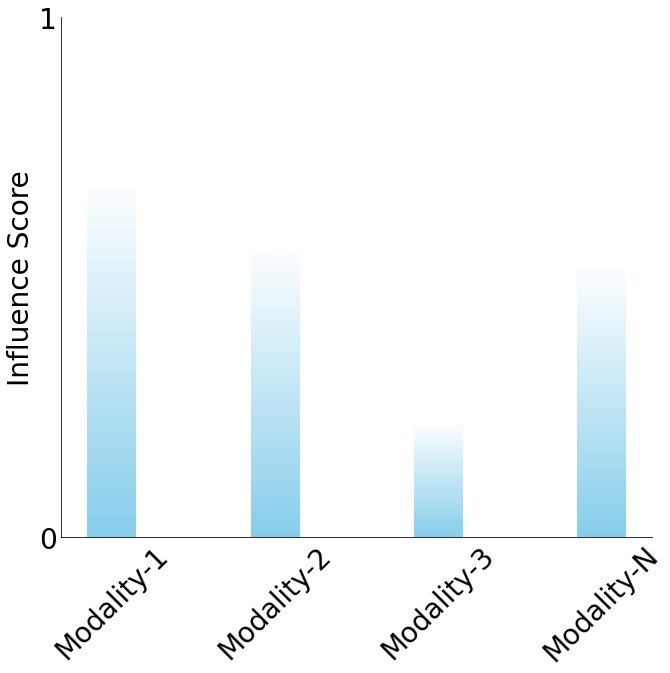

In [4]:
import numpy as np

def gradientbars(bars):
      cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","skyblue"])

      ax = bars[0].axes
      lim = ax.get_xlim()+ax.get_ylim()
      for bar in bars:
          
          bar.set_zorder(1)
          bar.set_facecolor("none")
          x,y = bar.get_xy()
          w, h = bar.get_width(), bar.get_height()
          grad = np.atleast_2d(np.linspace(0,1,256)).T
          ax.imshow(grad, extent=[x,x+w,y,y+h], cmap=cmap, aspect="auto", zorder=0, norm=matplotlib.colors.NoNorm(vmin=0,vmax=1))
      ax.axis(lim)  


from matplotlib import pyplot as plt
import matplotlib

           
matplotlib.rcParams.update({'font.size': 28})

HLINES = [0, 0.5, 1]

data = {'Modality-1':0.68,
        'Modality-2':0.56,
        'Modality-3':0.22,
         'Modality-N':0.52}

courses = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(figsize=(10,10))
 
# Customize labels and ticks
axs.tick_params(length=0)
axs.set_yticks(HLINES)
axs.set_yticklabels(HLINES, size=28)
axs.set_ylabel("Influence Score", size=28)

# creating the bar plot
bar_ = plt.bar(courses, values, color="skyblue", width = 0.3)
axs.get_yaxis()
gradientbars(bar_)
plt.xticks(rotation=45)
plt.yticks([0,1])

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
#axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(True)
fig.tight_layout()
plt.savefig('scores_viz_2.png', transparent=True, dpi=500)
plt.show()

In [3]:
import os
os.chdir('/ws/git_naturalness_influence/NEW')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

from ni_dataset import MapInWild_Naturalness
from custom_unet import UNet
from pl_trainer import UNetSimple

import albumentations as A
import numpy as np
import torch
from tqdm.auto import tqdm

from helpers import get_channels, stretch, cmap, convert_to_color_wc

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


%load_ext autoreload
%autoreload 2

Global seed set to 42
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#dataset args

dataset_root = '/data/Dataset_'
split_file = '/data/aux_/split_IDs/tvt_split.csv'
subset_file = '/data/aux_/single_temporal_subset/single_temporal_subset.csv'
bands = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad")
crop_size = (1920,1920)
batch_size = 16
#args
device = "cuda"
checkpoint_path = "./unetsimple_checkpoints/last__bolu4_seloss_w_sigmoid_v3_16_256epoch=09-val_loss=0.14.ckpt"
test_transform = A.Compose([A.RandomCrop(crop_size[0], crop_size[1], p=1.0)])


train_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='train', 
                                bands= bands, subsetpath = subset_file, transforms=None)

val_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='validation', 
                                bands= bands, subsetpath = subset_file, transforms=None)
test_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='test', 
                                bands= bands, subsetpath = subset_file, transforms=None)

In [5]:
model = UNetSimple(input_size=crop_size)

model = model.load_from_checkpoint(checkpoint_path= checkpoint_path,
                          map_location= device, input_size = (1920,1920))
model = model.eval()

UNET_SE:v
UNET_SE:v


---

In [6]:
ids = np.sort(test_dataset.ids)
ids, len(ids)

(array([       58,        64,       132,       393,       566,       924,
             1425,      1521,      1917,      2517,      6138,     10369,
            11829,     13390,     16385,     18367,     18415,     18569,
            18704,     19428,     19442,     23114,     26086,     27656,
            30605,     30745,     33047,     39516,     63831,     63892,
            64080,     64113,     68851,     71274,     76548,     76820,
           100018,    100205,    101409,    115769,    126263,    126281,
           126404,    126418,    126767,    127776,    145483,    167118,
           301929,    306816,    310055,    313189,    313663,    313672,
           314891,    342356,    346056,    351819,    354196,    365292,
           365380,    368134,    368950,    374681,    376024,    376820,
           389022,    395341,  11115306,  11115337,  90000005, 555557526,
        555557743, 555557769, 555565583, 555566942, 555569948, 555576316,
        555587037, 555603882, 55562430

In [7]:
idx = test_dataset.ids.index(900000099)
idx

99

In [8]:
image_mask = test_dataset[idx]
wdpa_id = image_mask[-1]
input = torch.Tensor(np.expand_dims(image_mask[0], 0)).to(device)
tabular = torch.zeros(1,14).to(device)

logits_reg, clsf, factors = model.model.forward(input,tabular)
reg =logits_reg.detach().cpu().numpy()

In [9]:
logits_reg.shape, clsf.shape, factors.shape

(torch.Size([1, 1, 1920, 1920]), torch.Size([1, 1]), torch.Size([1, 14, 1, 1]))

In [10]:
image = image_mask[0]
gt_mask = image_mask[1]

all_bands = "VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad"
rgb_s2 = get_channels(im = image, all_channels = all_bands, select_channels = ['B4', 'B3', 'B2'])
s1 = get_channels(im = image, all_channels = all_bands, select_channels = ['VH'])
esa_wc = get_channels(im = image, all_channels = all_bands, select_channels = ['2020_Map'])
viirs = get_channels(im = image, all_channels = all_bands, select_channels = ['avg_rad'])

s2_im = stretch(np.transpose(rgb_s2.numpy(),(1,2,0)))

gt_mask = gt_mask.squeeze()

pr_mask = logits_reg.detach().cpu().numpy().squeeze()


esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())

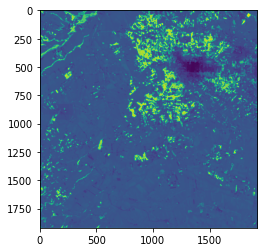

In [11]:
plt.imshow(pr_mask)

In [ ]:
esa_wc.max(),esa_wc.min()

In [ ]:
viirs.max(),viirs.min()

In [ ]:
s1.max(),s1.min()

In [ ]:
rgb_s2.max(),rgb_s2.min()

In [ ]:
gt_mask.max(),gt_mask.min()

In [ ]:
pr_mask.max(),pr_mask.min()

In [ ]:
viirs.shape

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

def integer_decode(normalized_array):
    min_val = 10.0
    max_val = 100.0
    original_array = normalized_array * (max_val - min_val) + min_val
    return original_array

def plot_images_six(idx, test_dataset, model, device, cmap, save=False):
    # Get your data from test_dataset and model using idx, device, etc.
    # For example:
    # s2_im, s1, esa_color, viirs, gt_mask, pr_mask = some_function_to_get_data(idx, test_dataset, model, device)
    
    # Extract image and mask from the dataset
    image_mask = test_dataset[idx]
    wdpa_id = image_mask[-1]
    input = torch.Tensor(np.expand_dims(image_mask[0], 0)).to(device)
    tabular = torch.zeros(1, 14).to(device)

    # Forward pass through the model
    logits_reg, patch_reg, factor = model.model.forward(input, tabular)
    patch_reg = patch_reg.detach().cpu().numpy()

    image = image_mask[0]
    gt_mask = image_mask[1]

    all_bands = "VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad"
    rgb_s2 = get_channels(im = image, all_channels = all_bands, select_channels = ['B4', 'B3', 'B2'])
    s1 = get_channels(im = image, all_channels = all_bands, select_channels = ['VH'])
    esa_wc = get_channels(im = image, all_channels = all_bands, select_channels = ['2020_Map'])
    viirs = get_channels(im = image, all_channels = all_bands, select_channels = ['avg_rad'])

    s2_im = stretch(np.transpose(rgb_s2.numpy(),(1,2,0)))

    gt_mask = gt_mask.squeeze()

    pr_mask = logits_reg.detach().cpu().numpy().squeeze()


    esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
#     esa_wc_inteight=np.rint(integer_decode(esa_wc))
    esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())

    
    fig = plt.figure(figsize=(16, 22))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, 6),
                     axes_pad=0.2,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="5%",
                     cbar_pad=0.05)  # Increase the padding

    # Your image plotting code
    grid[0].imshow(s2_im)
    grid[0].axis('off')
    grid[0].set_title(f"{wdpa_id} Sentinel-2")

    grid[1].imshow(s1.squeeze())
    grid[1].axis('off')
    grid[1].set_title("Sentinel-1")

    grid[2].imshow(esa_color)
    grid[2].axis('off')
    grid[2].set_title("Land Cover Map")

    im_viirs = grid[3].imshow(viirs.squeeze(), cmap='BuPu')
    grid[3].axis('off')
    grid[3].set_title("Night-time light")

    grid[4].imshow(gt_mask * 100, cmap=cmap, vmin=0, vmax=100, interpolation='none')
    grid[4].axis('off')
    grid[4].set_title("Naturalness Annotation")

    imc = grid[5].imshow(pr_mask*100, cmap=cmap, vmin=0, vmax=80, interpolation='none')
    grid[5].axis('off')
    grid[5].set_title("Naturalness Prediction")
    plt.colorbar(imc, cax=grid.cbar_axes[0], label='Naturalness')
    if save:
        plt.savefig(f'./viz/predictions/{wdpa_id}_prediction1920_0809.png', transparent=True, dpi=200)
    plt.show()

  0%|          | 0/102 [00:00<?, ?it/s]

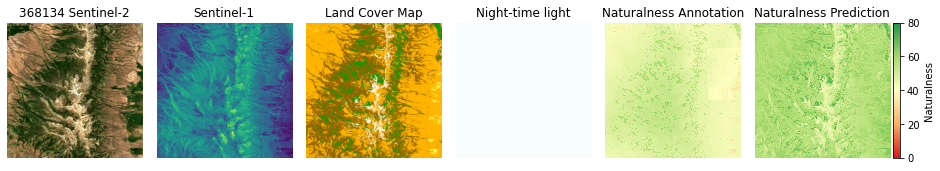

  1%|          | 1/102 [00:02<04:43,  2.81s/it]

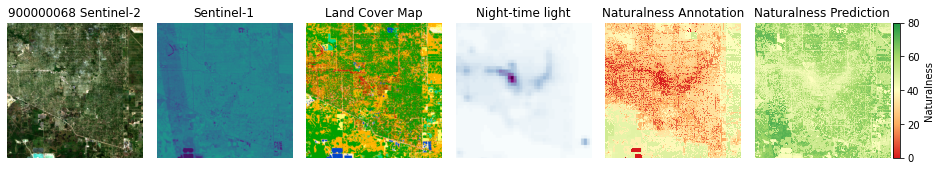

  2%|▏         | 2/102 [00:05<04:33,  2.74s/it]

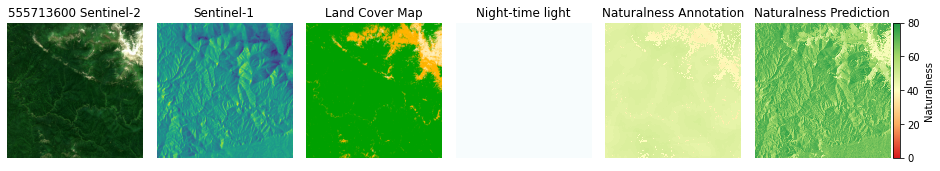

  3%|▎         | 3/102 [00:08<04:27,  2.71s/it]

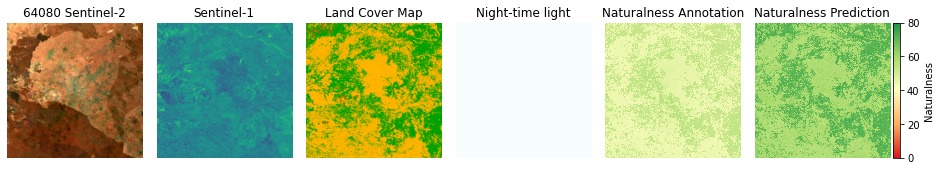

  4%|▍         | 4/102 [00:10<04:25,  2.71s/it]

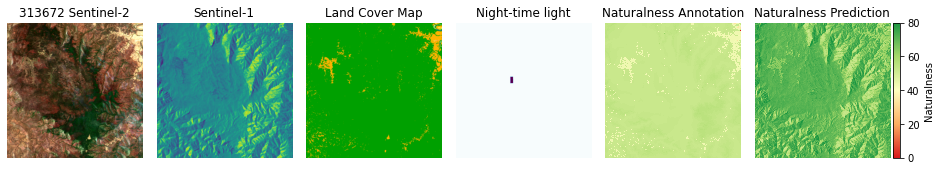

  5%|▍         | 5/102 [00:13<04:18,  2.66s/it]

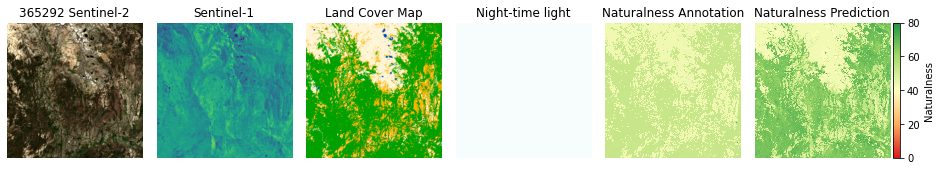

  6%|▌         | 6/102 [00:16<04:14,  2.65s/it]

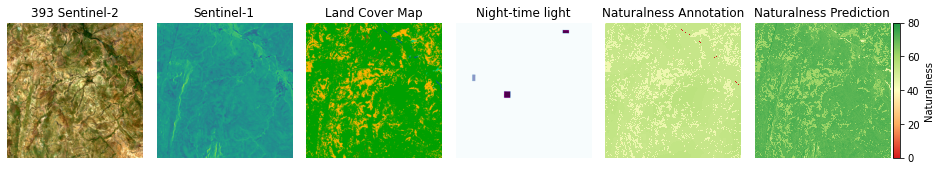

  7%|▋         | 7/102 [00:20<04:42,  2.97s/it]


KeyboardInterrupt: 

In [13]:
for i in tqdm(range(len(test_dataset))):
    plot_images_six(idx=i, test_dataset=test_dataset, model=model, device=device, cmap=cmap, save=False)

# Other viz

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_images(idx, test_dataset, model, device, cmap, save=False):
    # Extract image and mask from the dataset
    image_mask = test_dataset[idx]
    wdpa_id = image_mask[-1]
    input = torch.Tensor(np.expand_dims(image_mask[0], 0)).to(device)
    tabular = torch.zeros(1, 14).to(device)

    # Forward pass through the model
    logits_reg, patch_reg, factors = model.model.forward(input, tabular)
    patch_reg = patch_reg.detach().cpu().numpy()

    # Extract individual bands and masks
    image = image_mask[0]
    gt_mask = image_mask[1]
    all_bands = "VV", "VH", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12", "2020_Map", "avg_rad"
    
    # Assuming get_channels is a function you've defined elsewhere
    rgb_s2 = get_channels(im=image, all_channels=all_bands, select_channels=['B4', 'B3', 'B2'])
    s1 = get_channels(im=image, all_channels=all_bands, select_channels=['VH'])
    esa_wc = get_channels(im=image, all_channels=all_bands, select_channels=['2020_Map'])
    viirs = get_channels(im=image, all_channels=all_bands, select_channels=['avg_rad'])

    s2_im = stretch(np.transpose(rgb_s2.numpy(), (1, 2, 0)))  # Assuming stretch is a function you've defined elsewhere
    
    esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
#     esa_wc_inteight=np.rint(integer_decode(esa_wc))
    esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())

    gt_mask = gt_mask.squeeze()
    pr_mask = logits_reg.detach().cpu().numpy().squeeze()

    # Plotting
    fig = plt.figure(figsize=(16, 22))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, 6),
                     axes_pad=0.05,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="5%",
                     cbar_pad=0.05)

    # Your image plotting code
    grid[0].imshow(s2_im)
    grid[0].axis('off')
    grid[0].set_title(f"{wdpa_id} Sentinel-2")

    grid[1].imshow(s1.squeeze())
    grid[1].axis('off')
    grid[1].set_title("Sentinel-1")

    grid[2].imshow(esa_color)
    grid[2].axis('off')
    grid[2].set_title("Land Cover Map")

    im_viirs = grid[3].imshow(viirs.squeeze(), cmap='BuPu')
    grid[3].axis('off')
    grid[3].set_title("Night-time light")

    grid[4].imshow(gt_mask * 100, cmap=cmap, vmin=0, vmax=100, interpolation='none')
    grid[4].axis('off')
    grid[4].set_title("Naturalness Annotation")

    imc = grid[5].imshow(pr_mask*100, cmap=cmap, vmin=0, vmax=80, interpolation='none')
    grid[5].axis('off')
    grid[5].set_title("Naturalness Prediction")
    plt.colorbar(imc, cax=grid.cbar_axes[0], label='Naturalness')
    if save:
        plt.savefig(f'./viz/predictions/{wdpa_id}_prediction1920_0809.svg', transparent=True, dpi=100)
    plt.show()


In [ ]:
plot_images(idx=test_dataset.ids.index(900000068), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

In [ ]:
plot_images(idx=test_dataset.ids.index(900000023), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

In [ ]:
plot_images(idx=test_dataset.ids.index(900000068), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

In [ ]:
plot_images(idx=test_dataset.ids.index(900000070), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

In [ ]:
plot_images(idx=test_dataset.ids.index(900000099), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

In [ ]:
plot_images(idx=test_dataset.ids.index(900000087), test_dataset=test_dataset, model=model, device=device, cmap=cmap)

### viz for paper

1

In [ ]:
vv = get_channels(im = image, all_channels = all_bands, select_channels = ['VV']).squeeze()
vh = get_channels(im = image, all_channels = all_bands, select_channels = ['VH']).squeeze()
_2020_Map = get_channels(im = image, all_channels = all_bands, select_channels = ['2020_Map']).squeeze()
avg_rad = get_channels(im = image, all_channels = all_bands, select_channels = ['avg_rad']).squeeze()
b2 = get_channels(im = image, all_channels = all_bands, select_channels = ['B2']).squeeze()
b3 = get_channels(im = image, all_channels = all_bands, select_channels = ['B3']).squeeze()
b4 = get_channels(im = image, all_channels = all_bands, select_channels = ['B4']).squeeze()
b5 = get_channels(im = image, all_channels = all_bands, select_channels = ['B5']).squeeze()
b6 = get_channels(im = image, all_channels = all_bands, select_channels = ['B6']).squeeze()
b7 = get_channels(im = image, all_channels = all_bands, select_channels = ['B7']).squeeze()
b8 = get_channels(im = image, all_channels = all_bands, select_channels = ['B8']).squeeze()
b8a = get_channels(im = image, all_channels = all_bands, select_channels = ['B8A']).squeeze()
b11 = get_channels(im = image, all_channels = all_bands, select_channels = ['B11']).squeeze()
b12 = get_channels(im = image, all_channels = all_bands, select_channels = ['B12']).squeeze()

band_names = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad")
bands = (vv, vh, b2, b3, b4, b5, b6, b7, b8, b8a, b11, b12, _2020_Map, avg_rad)

for names, band in zip(band_names, bands):
    plt.imshow(stretch(band), cmap='Greys')
    plt.axis('off')
    fig.tight_layout()
    plt.savefig(f'./viz/{names}.png', transparent=True, dpi=500)
    plt.show()

2

In [ ]:
wdpa_id = 900000068
idx = test_dataset.ids.index(wdpa_id)

In [ ]:
image_mask = test_dataset[idx]
wdpa_id = image_mask[-1]
input = torch.Tensor(np.expand_dims(image_mask[0], 0)).to(device)
tabular = torch.zeros(1, 14).to(device)

# Forward pass through the model
logits_reg, patch_reg, factors = model.model.forward(input, tabular)
patch_reg = patch_reg.detach().cpu().numpy()

# Extract individual bands and masks
image = image_mask[0]
gt_mask = image_mask[1]
all_bands = "VV", "VH", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12", "2020_Map", "avg_rad"

# Assuming get_channels is a function you've defined elsewhere
rgb_s2 = get_channels(im=image, all_channels=all_bands, select_channels=['B4', 'B3', 'B2'])
s1 = get_channels(im=image, all_channels=all_bands, select_channels=['VH'])
esa_wc = get_channels(im=image, all_channels=all_bands, select_channels=['2020_Map'])
viirs = get_channels(im=image, all_channels=all_bands, select_channels=['avg_rad'])

s2_im = stretch(np.transpose(rgb_s2.numpy(), (1, 2, 0)))  # Assuming stretch is a function you've defined elsewhere

esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
#     esa_wc_inteight=np.rint(integer_decode(esa_wc))
esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())

gt_mask = gt_mask.squeeze()
pr_mask = logits_reg.detach().cpu().numpy().squeeze()

In [ ]:
vv = get_channels(im=image, all_channels=all_bands, select_channels=['VV']).squeeze()
vh = s1.squeeze()

In [ ]:
imc = plt.imshow(gt_mask*100, cmap=cmap, vmin=0, vmax=80, interpolation='none')
plt.axis('off')
# plt.colorbar(imc, label='Naturalness')
plt.savefig(f'./viz/paper_viz/network_sample_ni_GT_{wdpa_id}.svg', transparent=True)

In [ ]:
imc = plt.imshow(pr_mask*100, cmap=cmap, vmin=0, vmax=80, interpolation='none')
plt.axis('off')
# plt.colorbar(imc, label='Naturalness')
plt.savefig(f'./viz/paper_viz/network_sample_ni_pred_{wdpa_id}.svg', transparent=True)

In [ ]:
plt.imshow(s2_im)
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_s2_{wdpa_id}.svg', transparent=True)

In [ ]:
plt.imshow(stretch(vh.numpy()), cmap='Greys')
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_vh_{wdpa_id}.svg', transparent=True)

In [ ]:
plt.imshow(stretch(vh.numpy()), cmap='Greys')
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_vh_{wdpa_id}.svg', transparent=True)

In [ ]:
plt.imshow(stretch(vv.numpy()), cmap='Greys')
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_vv_{wdpa_id}.svg', transparent=True)

In [ ]:
plt.imshow(esa_color)
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_vv_{wdpa_id}.svg', transparent=True)


In [ ]:
plt.imshow(viirs.squeeze(),cmap='BuPu')
plt.axis('off')
plt.savefig(f'./viz/paper_viz/network_sample_viirs_{wdpa_id}.svg', transparent=True)

3

In [ ]:
id = 372358
# id = 900000093
# id = 19442
if id in train_dataset.ids:
    idx = train_dataset.ids.index(id)
    image_mask = train_dataset[idx]
    print("Train")
if id in val_dataset.ids:
    idx = val_dataset.ids.index(id)
    image_mask = val_dataset[idx]
    print("Val")
if id in test_dataset.ids:
    idx = test_dataset.ids.index(id)
    image_mask = test_dataset[idx]
    print("Test")

wdpa_id = image_mask[-1]

image = image_mask[0]
gt_mask = image_mask[1]

all_bands = "VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad"
rgb_s2 = get_channels(im = image, all_channels = all_bands, select_channels = ['B4', 'B3', 'B2'])
s1 = get_channels(im = image, all_channels = all_bands, select_channels = ['VH'])
esa_wc = get_channels(im = image, all_channels = all_bands, select_channels = ['2020_Map'])
viirs = get_channels(im = image, all_channels = all_bands, select_channels = ['avg_rad'])

s2_im = stretch(np.transpose(rgb_s2.numpy(),(1,2,0)))

gt_mask = gt_mask.squeeze()

esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1, 5, figsize=(16, 22))

# Plot data
im1 = axes[0].imshow(s2_im)
axes[0].axis('off')
# axes[0].set_title('Sentinel-2')

im2 = axes[1].imshow(stretch(s1.numpy().squeeze()), 'Greys')
axes[1].axis('off')
# axes[1].set_title('Sentinel-1')

im3 = axes[2].imshow(esa_color)
axes[2].axis('off')
# axes[2].set_title('ESA WorldCover')

im4 = axes[3].imshow(viirs.squeeze(), cmap='BuPu')
axes[3].axis('off')
# axes[3].set_title('VIIRS DNB')

im5 = axes[4].imshow(gt_mask * 100, cmap=cmap, vmin=0, vmax=100, interpolation='none')
axes[4].axis('off')
# axes[4].set_title('Naturalness Annotation')

# if viirs.mean() <1:
#     kwargs = {'format': '%.1f'}
# Add colorbars to plots with odd numbers
divider4 = make_axes_locatable(axes[3])
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbb =plt.colorbar(im4, cax=cax4)
cbb.outline.set_visible(False)


divider6 = make_axes_locatable(axes[4])
cax6 = divider6.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im5, cax=cax6)
cb.outline.set_visible(False)

plt.savefig(f'./viz/paper_viz/{wdpa_id}_viz.svg', bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
viirs.max() 

In [ ]:
viirs.mean()

In [1]:
WC_palette =  ["Tree cover","Shrubland","Grassland","Cropland","Built-up","Bare / sparse vegetation" ,"Snow and ice","Permanent water bodies","Herbaceous wetland","Mangroves","Moss and lichen"]
colors = [(0,100,0),(255, 187, 34),(255, 255, 76),(240, 150, 255),(250, 0, 0),(180, 180, 180),(240, 240, 240),(0, 100, 200),(0, 150, 160),(0, 207, 117),(250, 230, 160)]
clrs = np.asarray(colors)/255

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
colors = clrs
texts = WC_palette
fig = plt.figure(figsize=(42, 22))

import pylab as plot
params = {'legend.fontsize': 30,
          'legend.handlelength': 0.8}
plot.rcParams.update(params)

patches = [ plt.plot([],[], marker="s", ms=30, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.6), 
           loc='center', ncol=6, facecolor="ghostwhite", numpoints=1, frameon=False)
plt.savefig(f'./viz/paper_viz/legend_viz.svg', bbox_inches='tight', transparent=True, dpi=100)

plt.show()

NameError: name 'np' is not defined